## Exemplo: Aceleração da convergência.

Neste exemplo veremos que o termo momentum pode acelerar a convergência do gradiente descendente.

In [1]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import random

### Semente que será usada ao longo do exemplo.

In [2]:
seed = 0

### Definição de funções.

In [3]:
def errorSurface(x1, x2, y_noisy):
    # Retrieve the number of samples.
    N = len(y_noisy)
    # Generate values for parameters.
    M = 200
    a1 = np.linspace(-2.0, 10.0, M)
    a2 = np.linspace(-2.0, 10.0, M)

    A1, A2 = np.meshgrid(a1, a2)

    # Generate points for plotting the cost-function surface.
    J = np.zeros((M,M))
    for iter1 in range(0, M):
        for iter2 in range(0, M):
            # Hypothesis function.
            yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
            J[iter1, iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat))
    
    return A1, A2, J

def normalEquation(X, y_noisy):
    # Retrieve number of samples.
    N = len(y_noisy)
    
    # Closed-form solution.
    a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

    # Hypothesis function.
    yhat = X.dot(a_opt)

    # Mean Squared Error.
    Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))
    
    return Joptimum, a_opt

# learning schedule: Decaimento temporal
def timeBasedDecay(alpha_int, k, t):
    return alpha_int / (1 + k*t)

# learning schedule: Exponential Decay.
def exponentialDecay(alpha_int, k, t):
    return alpha_int * np.exp(-k*t)

def stepDecay(alpha_int, t, drop=0.5, epochs_drop = 4.0):
    alpha = alpha_int * math.pow(drop, math.floor((1+t)/epochs_drop))
    return alpha

def learning_schedule(typels, alpha_int, t, k=0.01, mu=0.9):
    if(typels=='exp'):
        mom = 0.0
        alpha = exponentialDecay(alpha_int, k, t)
    elif(typels=='time'):
        mom = 0.0
        alpha = timeBasedDecay(alpha_int, k, t)
    elif(typels=='step'):
        mom = 0.0
        alpha = stepDecay(alpha_int, t)
    elif(typels=='mom'):
        mom = mu
        alpha = alpha_int
    elif(typels=='momstep'):
        mom = mu
        alpha = stepDecay(alpha_int, t)
    else:
        mom = 0.0
        alpha = alpha_int
    return alpha, mom

def mbgd(X, y_noisy, n_epochs, typels, alpha_init, k=0.01, mu=0.9, mb_size=5):
    '''Mini-batch Gradient Descent implementation.'''
    
    # Number of examples.
    N = len(y_noisy)
    
    # Random initialization of parameters.
    a = np.array([-2.0, -2.0]).reshape(2, 1)

    # Create vector for parameter history.
    a_hist = np.zeros((2, n_epochs*(N//mb_size)+1))

    # Initialize history vector.
    a_hist[:, 0] = a.reshape(2,)

    # Create vector to store eta history.
    alpha_hist = np.zeros((n_epochs*(N//mb_size)))

    # Momentum term.
    v = np.zeros((2, 1))

    # Create array for storing error values.
    Jgd = np.zeros((n_epochs+1,))

    # Calculate initial MSE.
    Jgd[0] = (1.0/N)*sum(np.power(y_noisy - X.dot(a), 2))

    update_hist = np.zeros((2, n_epochs*(N//mb_size)))

    # Mini-batch gradient-descent loop.
    inc = 0
    for epoch in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        random_indexes = random.sample(range(0, N), N)  
            
        # Update the weights with the mini-batches.
        for i in range(0, N//mb_size):
            # Randomly selecting one mini-batch for training.
            start = i*mb_size
            end = mb_size*(i+1)
            mb_indexes = random_indexes[start:end]        
            Xi = X[mb_indexes]
            yi = y_noisy[mb_indexes]

            # Update the learning rate value.
            alpha, mu = learning_schedule(typels, alpha_init, inc, k, mu)
            
            # Estimate the gradient with just one sample.
            gradient = -(1.0/mb_size)*Xi.T.dot(yi - Xi.dot(a))
            
            # Update the weights with the momentum term.
            v = mu*v + (1 - mu)*gradient
            a = a - alpha*v

            # Update arrays with history values.
            a_hist[:, inc+1] = a.reshape(2,)
            update_hist[:, inc] = v.reshape(2,)
            alpha_hist[inc] = alpha
            
            # Iteration counter.
            inc += 1

        # Calculate the current MSE.
        Jgd[epoch] = (1.0/N)*sum(np.power((y_noisy - X.dot(a)), 2))

    return a, Jgd, a_hist, update_hist, alpha_hist, inc

### Gerando dados para uma superfície de erro circular.

O intervalo de variação dos atributos é similar.

In [4]:
# Always reset the pseudo random number generator to the same number.
np.random.seed(seed)
random.seed(seed)

In [5]:
# Define the number of examples.
N = 100

# Features.
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = 4 * x1 + 4 * x2

# Observable model.
y_noisy = y + w

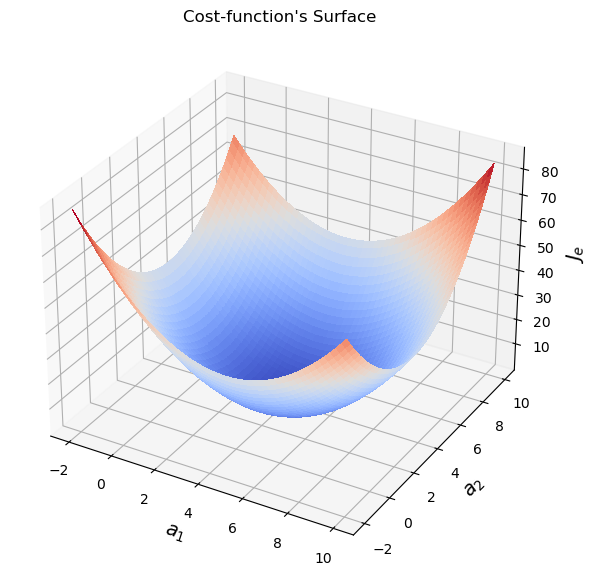

In [6]:
# Calculate the error surface.
A1, A2, J = errorSurface(x1, x2, y_noisy)

# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
#Show the plot.
plt.show()

### Encontrando a solução ótima.

In [7]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Calculate optimum weights.
Joptimum, a_opt = normalEquation(X, y_noisy)

# Print a1 and a2 weights.
print('peso a1:', a_opt[0, 0])
print('peso a2:', a_opt[1, 0])
# Print the optimum MSE.
print('Erro:', Joptimum)

peso a1: 4.063454839808392
peso a2: 4.039574578360914
Erro: 0.9034158375788076


### Econtrando a solução com GD em batelada sem termo momentum.

In [8]:
# Always reset the pseudo random number generator to the same number.
np.random.seed(seed)
random.seed(seed)

In [9]:
# Number of epochs.
n_epochs = 50

# Learning rate.
alpha_gd = 0.1

# Mini batch size
mb_size = N

# mini-batch GD.
a_gd, Jgd, a_hist, update_hist, alpha_hist, inc = mbgd(X, y_noisy, n_epochs, 'none', alpha_gd, 0.01, 0.0, mb_size)

# Print a1 and a2 weights.
print('peso a1:', a_gd[0, 0])
print('peso a2:', a_gd[1, 0])

peso a1: 4.046909177917302
peso a2: 4.03151420938975


#### Superfície de contorno com histórico de atualização dos pesos.

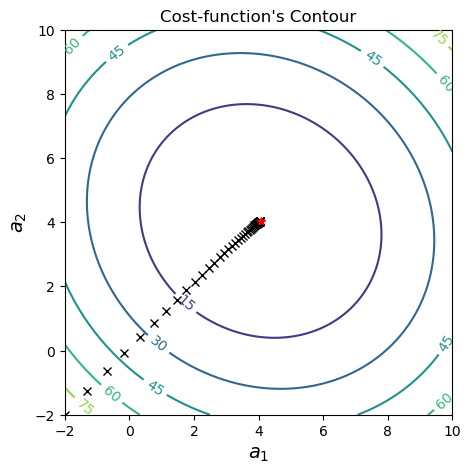

In [10]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_hist[0, 0:inc+1], a_hist[1, 0:inc+1], 'kx')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.xticks(np.arange(-2, 12, step=2.0))
plt.yticks(np.arange(-2, 12, step=2.0))
plt.show()

#### Observações

+ GD caminha rapidamente para o ponto de mínimo, seguindo a direção de máxima declividade da função.


+ Todos os vetores gradiente têm o mesmo sinal, ou seja, não mudam de direção a cada iteração.

#### Variação dos vetores gradiente e update.

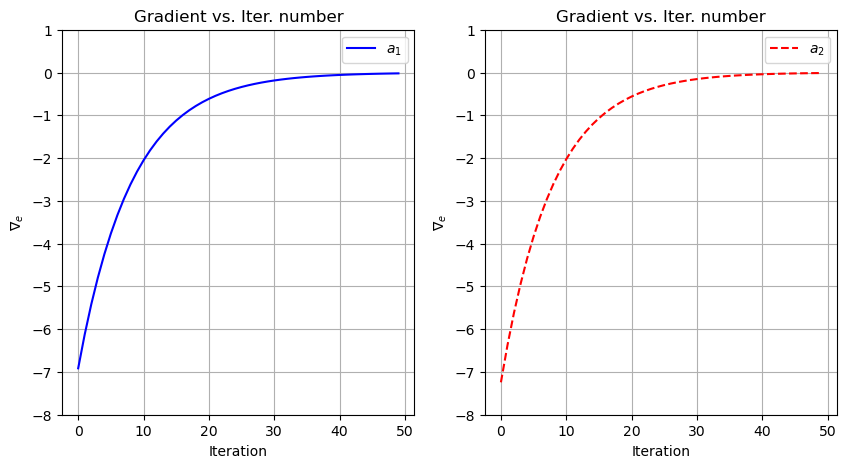

In [11]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, inc), update_hist[0,0:inc], 'b', label='$a_1$')
ax1.set_ylim([-8, 1])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, inc), update_hist[1,0:inc], 'r--', label='$a_2$')
ax2.set_ylim([-8, 1])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number')
ax2.legend()
ax2.grid()

plt.show()

In [12]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:', var1)
print('var a2:', var2)

var a1: 2.9702908451034333
var a2: 3.2110289665669827


#### Observações

+ Como os atributos têm intervalos de variação semelhantes, o erro e, consequentemente, o gradiente, variam de forma semelhante em ambas as direções.

### Econtrando a solução com GD em batelada com termo momentum.

In [13]:
# Always reset the pseudo random number generator to the same number.
np.random.seed(seed)
random.seed(seed)

In [14]:
# Number of epochs.
n_epochs = 50

# Learning rate.
alpha_mom = 0.1

# Mini-batch size
mb_size = N

# Coefficient of momentum.
mu = 0.65

# Mini-batch GD.
a_mom, Jgd_mom, a_hist, update_hist, alpha_hist, inc = mbgd(X, y_noisy, n_epochs, 'mom', alpha_mom, 0.01, mu, mb_size)

# Print a1 and a2 weights.
print('peso a1:', a_mom[0, 0])
print('peso a2:', a_mom[1, 0])

peso a1: 4.062000614993232
peso a2: 4.041052560682972


#### Superfície de contorno com histórico de atualização dos pesos.

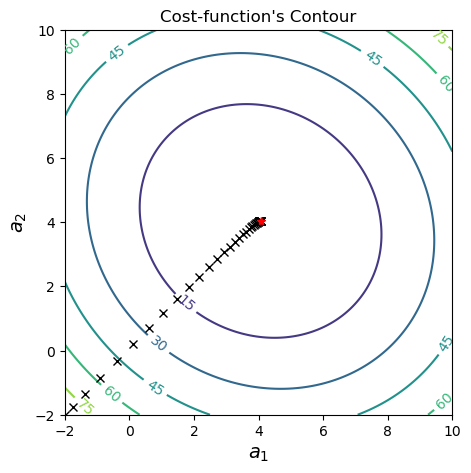

In [15]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_hist[0, 0:inc+1], a_hist[1, 0:inc+1], 'kx')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.xticks(np.arange(-2, 12, step=2.0))
plt.yticks(np.arange(-2, 12, step=2.0))
plt.show()

#### Observações

+ Quando todos os gradientes anteriores apontam na mesma direção, ou seja, têm o mesmo sinal:

    * O termo de atualização ficará maior e daremos grandes passos ao atualizar os pesos. 

    * Mesmo que o passo de aprendizagem seja pequeno, todos os gradientes ao longo da curva têm a mesma direção (sinal), portanto, aumentando o momento e acelerando a descida (covergência).

#### Variação dos vetores gradiente e update.

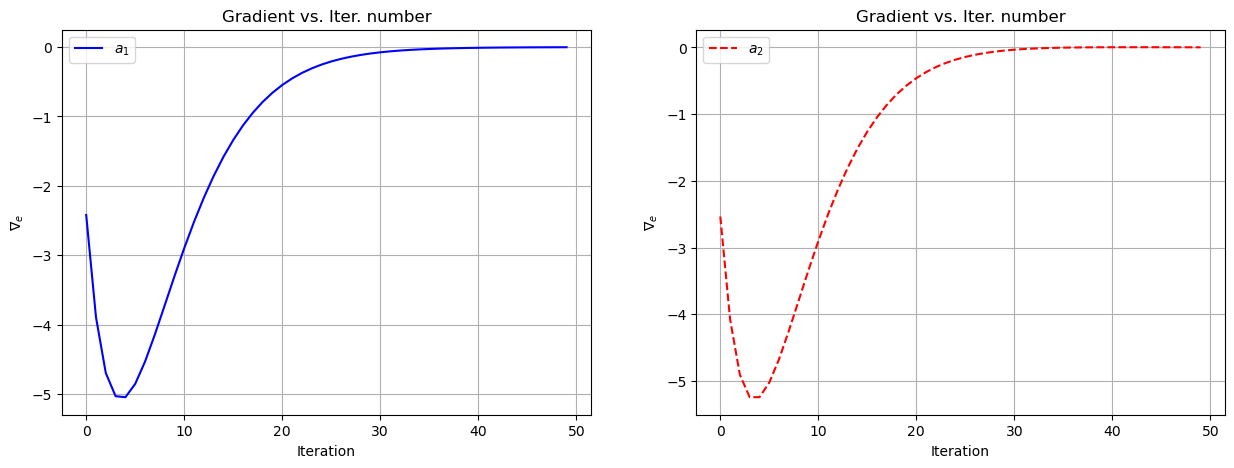

In [16]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, inc), update_hist[0,0:inc], 'b', label='$a_1$')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, inc), update_hist[1,0:inc], 'r--', label='$a_2$')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number')
ax2.legend()
ax2.grid()

plt.show()

In [17]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:', var1)
print('var a2:', var2)
print('var(a2)/var(a1):', var1/var2)

var a1: 2.758377692598014
var a2: 2.9862554340750904
var(a2)/var(a1): 0.9236911421317663


### Comparando versões com e sem o termo momentum.

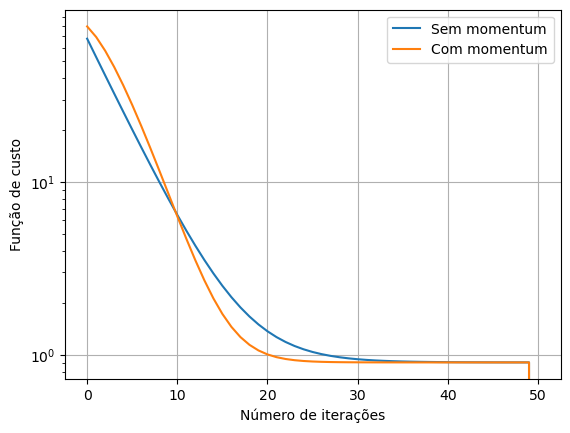

In [18]:
# Plotando a curva de aprendizado
plt.plot(Jgd, label='Sem momentum')
plt.plot(Jgd_mom, label='Com momentum')
plt.xlabel('Número de iterações')
plt.ylabel('Função de custo')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()